In [14]:
from psychopy import visual, event, core
import numpy as np
import matplotlib.pyplot as plt
import random

In [91]:
# Gabor Stimulus 
def ShowImage(image):
    plt.imshow(image, cmap='gray', vmin=-1, vmax=1)
    plt.axis('off') 
    plt.show()

def GaborImage(ori, contrast = 0.5, size=512, sf = 5, noise_mean=0.0, noise_std=0.4):
    x = np.linspace(-1, 1, size)
    y = np.linspace(-1, 1, size)
    X, Y = np.meshgrid(x, y)

    if ori =='left':
        theta = np.deg2rad(-45)
    else:
        theta = np.deg2rad(45)
        
    X_rot = X * np.cos(theta) + Y * np.sin(theta)
    grating = contrast * np.cos(2 * np.pi * sf * X_rot)

    gauss =  np.exp(-(X**2 + Y**2) / (2 * 0.25**2))
    gabor = grating * gauss

    gabor = np.clip(gabor, -1, 1)
    noise = np.random.normal(loc=noise_mean, scale=noise_std, size=(size, size))
    gabor = np.clip(gabor + noise, -1, 1)
    return gabor


def GaborMask(size=128, frequency=5, sigma=0.3):
    mask = np.zeros((size, size), dtype=np.float32)
    x = np.linspace(-1, 1, size)
    y = np.linspace(-1, 1, size)
    X, Y = np.meshgrid(x, y)

    # Four key orientations to eliminate orientation bias
    orientations_deg = [0, 90, 45, 135]

    for deg in 2 * orientations_deg:
        theta = np.deg2rad(deg)
        phase = np.random.uniform(0, 2 * np.pi)  
        X_rot = X * np.cos(theta) + Y * np.sin(theta)
        grating = np.cos(2 * np.pi * frequency * X_rot + phase)
        envelope = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
        patch = grating * envelope
        mask += patch

    mask = ((mask - mask.min()) / (mask.max() - mask.min()) - 0.5) * 2
    return mask.astype(np.float32)

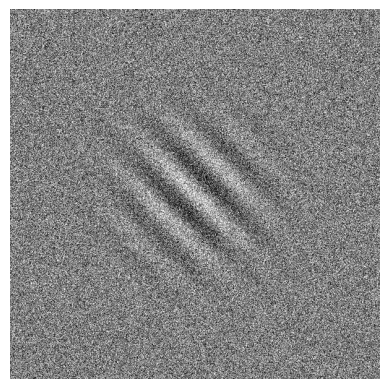

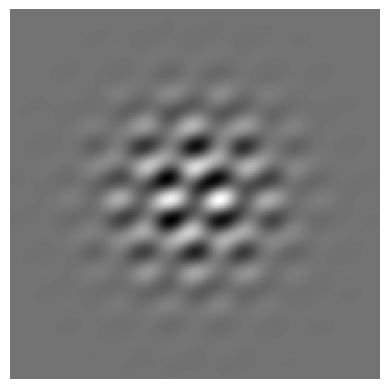

In [93]:
ShowImage(GaborImage(ori = 'left'))
ShowImage(GaborMask())

In [ ]:
# Visual Setup

win = visual.Window(size=(1920, 1080), color=0, units="pix", fullscr=True)
stim = visual.ImageStim(win, size=(512, 512), units="pix")

# Parameters
oris = ['left', 'right']
soa = 0.1
soa_practice = [0.1, 0.15, 0.2]
step_size = 0.005
n_trials = 50
n_practices = 10
noise_gap = 0.3
correct_counter = 0
data = []

# Instruction Screen
text = visual.TextStim(win, text="In this experiment, you will see a grating embedded in noise. The grating will be either up-to-right or up-to-left\
                                        The below one is an up-to-left grating.\
                                        \n\n The grating will be briefly flashed and then immediately masked by some random patterns, your task is to identify whether the grating is up-to-left or up-to-right after it is briefly presented at the center of the screen\
                                        \n\n If you think the grating is up-to-left, press 'x'. If you think the grating is up-to-right, press 'm'.\
                                        \n\n Press SPACE to continue", color=1.0, height=24, pos = (0, 300))
text.draw()
image = visual.ImageStim(image = np.flipud(GaborImage(ori= 'left')), win = win, size=(512, 512), pos = (0, -200), units="pix")
image.draw()
win.flip()
event.waitKeys(keyList=['space'])


# Practice trail screen
text = visual.TextStim(win, text="We will begin with several practice trials, feedback on correctness will be provided after each trial.\
                                \n\n If you think the grating is up-to-left, press 'x'. If you think the grating is up-to-right, press 'm'.\
                                \n\n Press SPACE to start the practice trials. ", color=1.0, height=24)
text.draw()
win.flip()
event.waitKeys(keyList=['space'])

for trial in range(n_practices):
    if 'escape' in event.getKeys():
        print("Experiment aborted by user.")
        break

    # Fixation
    fixation = visual.TextStim(win, text="+", color=1.0, height=48)
    fixation.draw()
    win.flip()
    core.wait(0.5)

    # Stimulus
    ori, practice_soa = random.choice(oris), random.choice(soa_practice)
    stim.image = np.flipud(GaborImage(ori = ori))
    stim.draw()
    win.flip()
    core.wait(practice_soa)
    stim.image = np.flipud(GaborMask())
    stim.draw()
    win.flip()
    core.wait(noise_gap)
    win.flip()

    # Decision
    wait = visual.TextStim(win, text="Choose the orientation", color=1.0, height=48)
    wait.draw()
    win.flip()
    keys = event.waitKeys(keyList=['x','m'] + ['escape'])
    if 'escape' in keys:
        print("Experiment aborted by user.")
        break

    response = 'left' if keys[0] == 'x' else 'right'
    correct = response == ori

    # Feedback 
    if correct:
        feedback_text = "Correct!"
        feedback_color = 'green'
    else:
        feedback_text = 'Wrong!'
        feedback_color = 'red'
    
    feedback = visual.TextStim(win, text=feedback_text, color=feedback_color, height=36)
    feedback.draw()
    win.flip()
    core.wait(0.5)  
    win.flip()
    core.wait(0.5)


# --- Main Staircase Block ---
text = visual.TextStim(win, text="Excellent! Here comes the main experiment. This time the task is more difficult, please pay attention\
                                \n\n If you think the grating is up-to-left, press 'x'. If you think the grating is up-to-right, press 'm'.\
                                \n\n Press SPACE to start the main experiment. ", color=1.0, height=34)
text.draw()
win.flip()
event.waitKeys(keyList=['space'])

for trial in range(n_trials):
    if 'escape' in event.getKeys():
        print("Experiment aborted by user.")
        break

    # Fixation
    fixation = visual.TextStim(win, text="+", color=1.0, height=48)
    fixation.draw()
    win.flip()
    core.wait(0.5)

    # Stimulus
    ori = random.choice(oris)
    stim.image = np.flipud(GaborImage(ori = ori))
    stim.draw()
    win.flip()
    core.wait(soa)
    stim.image = np.flipud(GaborMask())
    stim.draw()
    win.flip()
    core.wait(noise_gap)
    win.flip()

    # Decision
    wait = visual.TextStim(win, text="Choose the orientation", color=1.0, height=48)
    wait.draw()
    win.flip()
    keys = event.waitKeys(keyList=['x', 'm', 'escape'])
    if 'escape' in keys:
        print("Experiment aborted by user.")
        break
    win.flip()
    
    response = 'left' if keys[0] == 'x' else 'right'
    correct = response == ori
    data.append({"trial": trial+1, "orientation": ori, "response": response,
                 "correct": correct, "soa": soa})
    if correct:
        correct_counter += 1
        if correct_counter == 2:
            soa = max(0, soa - step_size)
            correct_counter = 0
    else:
        soa = min(1.0, soa + step_size)
        correct_counter = 0
    core.wait(0.5)
    print(soa)



# Cleanup 
win.close()

# ---------- Plot ----------
soas = [d["soa"] for d in data]
plt.figure(figsize=(8, 4))
plt.plot(range(1, n_trials + 1), soas, marker='o')
plt.xlabel("Trial")
plt.ylabel("Alpha (Visibility)")
plt.title("2-Down-1-Up Staircase")
plt.grid(True)
plt.show()

# Optional: save data
import pandas as pd
df = pd.DataFrame(data)
df.to_csv("Results.csv", index=False)